In [1]:
pip install catboost

Accuracy of CatBoost Model after SMOTE: 0.8487922705314009


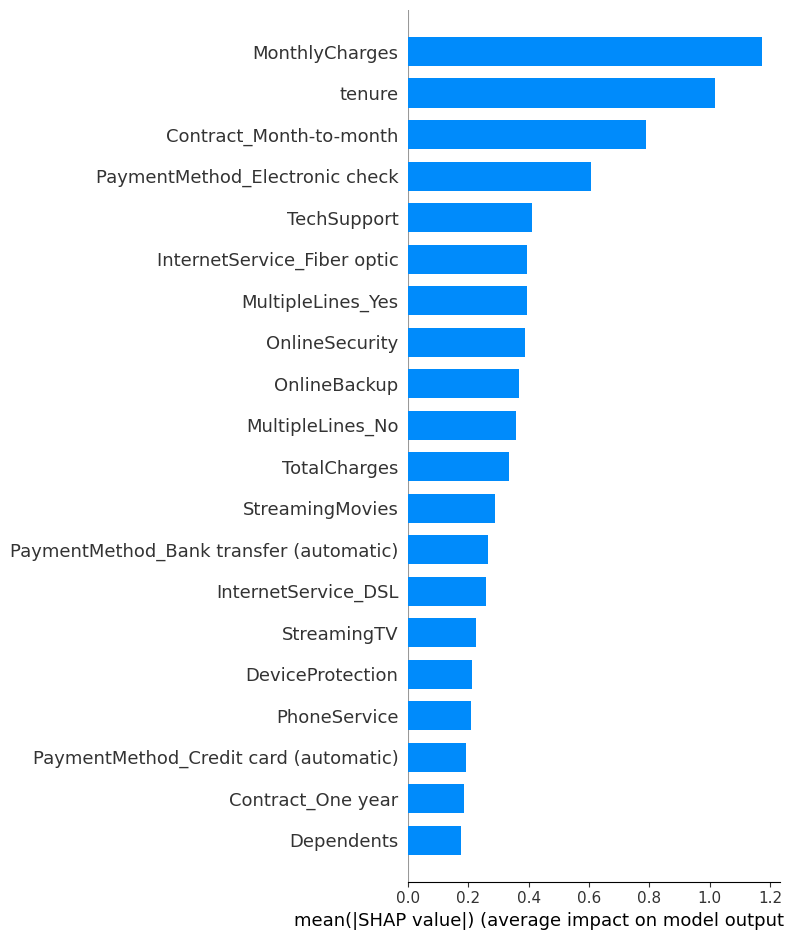

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.drop('customerID', axis=1, inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)
df['MultipleLines'] = df['MultipleLines'].replace('No phone service', 'No')
internet_columns = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in internet_columns:
    df[col] = df[col].replace('No internet service', 'No')

def replace_yes_no(df, columns):
    for col in columns:
        df[col] = df[col].replace({'Yes': 1, 'No': 0})

columns_to_replace = [
    "Partner", "Dependents", "PhoneService", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
    "PaperlessBilling", "Churn"
]

replace_yes_no(df, columns_to_replace)
binary_columns = ['gender']
le = LabelEncoder()
df[binary_columns] = df[binary_columns].apply(le.fit_transform)
df = pd.get_dummies(df, columns=['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod'])
scaler = StandardScaler()
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numerical_features] = scaler.fit_transform(df[numerical_features])
X = df.drop('Churn', axis=1)
y = df['Churn']
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
catboost_model = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='Logloss', verbose=0)
catboost_model.fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of CatBoost Model after SMOTE:", accuracy)
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")


In [ ]:
import joblib 

# Save the model using joblib
joblib.dump(catboost_model, 'catboost_model.pkl')

print("Model saved as 'catboost_model.pkl'")